# ex3  face recognition model  
# Rabi Rabi 312327331 

In [ ]:
import cv2 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import transform
import os
import random 
import glob
import albumentations as A
from torch.utils.data import Dataset,DataLoader
from functools import reduce
from sklearn.metrics import confusion_matrix
import gc

In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null
!pip install torchmetrics timm
import torchmetrics
import timm
from albumentations.pytorch import ToTensorV2

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-a_1ujh8e
     |████████████████████████████████| 276kB 7.5MB/s 
     |████████████████████████████████| 348kB 12.3MB/s 


# VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, n_classes):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc6 = nn.Linear(7*7*512, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 512)
        self.fc9 = nn.Linear(512 , n_classes)

    def forward(self, x, training=True):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool(x)
        x = x.view(-1,7*7*512)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, training=training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, training=training)
        x = F.relu(self.fc8(x))
        x = F.dropout(x, 0.5, training=training)
        x = self.fc9(x)
        return x

  



In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
data_path = os.path.join('/content/drive',"MyDrive","Faces", "Afeka_CV_2021")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g58f4AjbehzAVZgZABEI_68WadKSUvBpwMWug1Go53BwpeQ7VGnId0
Mounted at /content/drive


In [ ]:
train_images  = [glob.glob(os.path.join(data_path, d, "*.*")) for d in os.listdir(data_path)]

In [ ]:
# minimum suze based on the all images 
minemum_size = 55000
def check_size(image_path):
    image = cv2.imread(image_path)
    if image.shape[0]*image.shape[1] >= minemum_size:
        return True
    else:
        return False
    

In [ ]:
num_of_classes =len(train_images)

In [ ]:
images_path = np.hstack(train_images)

In [ ]:
names = set()
for path in images_path:
    names.add(path.split('/')[-2])

In [ ]:
name_2_num = {}
for index,name in enumerate(names):
    name_2_num[name] = index

In [ ]:
name_2_num

{'Almog Amiga': 5,
 'Assaf Hasky': 8,
 'Daniel Wurms': 4,
 'Eldad Ron': 21,
 'Evyatar Menczer': 2,
 'Gal Odentz': 12,
 'Guy Kabiri': 14,
 'Katya Boyko': 13,
 'Lior Toledano': 17,
 'Miriam Assraf': 1,
 'Nadav_Shaoulian': 15,
 'Nadir_Myers': 22,
 'Noam Levi': 20,
 'Oded Nir': 0,
 'Ofek Segev': 3,
 'Omri Kireev': 10,
 'Salo Elia': 18,
 'Shahar Michaeli': 9,
 'StavRabinovich': 11,
 'Tal Balelty': 7,
 'Tomer Dwek': 19,
 'jacob mon': 6,
 'math.pow(Rabi,2)': 16}

In [ ]:
num_2_name =dict()
for index in range(len(name_2_num)):
  num_2_name[list(name_2_num.values())[index]] = list(name_2_num.keys())[index]

In [ ]:
num_2_name

{0: 'Oded Nir',
 1: 'Miriam Assraf',
 2: 'Evyatar Menczer',
 3: 'Ofek Segev',
 4: 'Daniel Wurms',
 5: 'Almog Amiga',
 6: 'jacob mon',
 7: 'Tal Balelty',
 8: 'Assaf Hasky',
 9: 'Shahar Michaeli',
 10: 'Omri Kireev',
 11: 'StavRabinovich',
 12: 'Gal Odentz',
 13: 'Katya Boyko',
 14: 'Guy Kabiri',
 15: 'Nadav_Shaoulian',
 16: 'math.pow(Rabi,2)',
 17: 'Lior Toledano',
 18: 'Salo Elia',
 19: 'Tomer Dwek',
 20: 'Noam Levi',
 21: 'Eldad Ron',
 22: 'Nadir_Myers'}

In [ ]:
len(images_path)

462

In [ ]:
class imagesDataset(Dataset):
    def __init__(self, paths, transform = None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self ,idx):
        
        label = name_2_num[self.paths[idx].split("/")[-2]]
        image = cv2.imread(self.paths[idx])
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        if self.transform :
            image = self.transform(image= image)['image']
        return image  , label 
            
        

In [ ]:
images_dataset = imagesDataset(images_path)

In [ ]:
def get_all_sizes_df(all_images):
    all_sizes = pd.DataFrame(columns= ['index','image name' , 'row*col' ])
    row = 0 
    col = 0
    for i,image in enumerate(all_images):
        all_sizes.loc[i] = [i]+[image[1]] + [image[0].shape[0]* image[0].shape[1] ]
        
    return all_sizes

In [ ]:
df = get_all_sizes_df(images_dataset)

In [ ]:
df

,index,image name,row*col
0,0,17,5992704
1,1,17,5992704
2,2,17,5992704
3,3,17,5992704
4,4,17,5992704
...,...,...,...
457,457,16,9144576
458,458,16,9144576
459,459,16,9144576
460,460,16,9144576


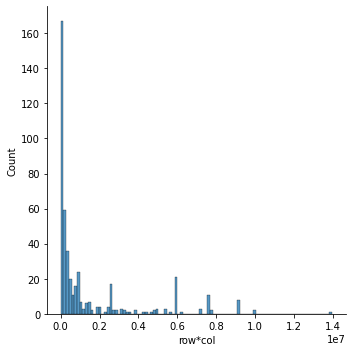

In [ ]:
sns.displot(data= df , x='row*col' ,bins= 100)

In [ ]:
print(f"percent of deleted data : {len(df[df['row*col'] < minemum_size]) / len(df) * 100} %")

percent of deleted data : 25.541125541125542 %


In [ ]:
images_path = list(filter(check_size ,list(images_path)) )

In [ ]:
random.shuffle(images_path)

In [ ]:
train_length = int(len(images_path) * 0.8)
train_path = []
test_path = []
for i in range(len(images_path)):
    if i < train_length:
        train_path.append(images_path[i])
    else:
        test_path.append(images_path[i])

In [ ]:
images_dataset = imagesDataset(train_path)
images_test_dataset = imagesDataset(test_path)

In [ ]:
#getting the smallest_image
# wanted to use it for zoom but i give up beacuse its ruing half of the images
def get_smallest_image(all_images):
    min_size = np.infty
    row = 0 
    col = 0
    for image in all_images:
        if image[0].shape[0]*image[0].shape[1] < min_size:
            min_size = image[0].shape[0]*image[0].shape[1]
            row = image[0].shape[0]
            col = image[0].shape[1]
    return row , col , 3
            

In [ ]:
min_size = get_smallest_image(images_dataset)
print(min_size)

In [ ]:
augmantations = A.Compose([ A.Resize(height= min_size[0],width=min_size[1], always_apply=True ),
                          A.MedianBlur(blur_limit = 1,p = 0.2),
                           A.HorizontalFlip(p = 0.2),
                           A.Rotate(border_mode=1,limit=45,p=0.2),
                           A.IAASharpen(p=0.2),
                           A.RandomBrightnessContrast(brightness_limit=0.1 , contrast_limit=0.1 ,p = 0.2),
                           A.Resize(height= 256,width=256, always_apply=True ),
                           A.CenterCrop(height= 224 , width = 224 , always_apply=True)
                          ])

In [ ]:
augmantations_1 = A.Compose([ A.Resize(height= 256,width=256, always_apply=True ),
                             A.CenterCrop(height= 224 , width = 224 , always_apply=True),
                           ToTensorV2()
                          ])

In [ ]:
my_dataset = imagesDataset(train_path , augmantations)

In [ ]:
def fix_image(image):
  image = image[0]
  image = np.array(((torch.tensor(image)).permute(2,1,0)))
  print(image.shape)
  return image

In [ ]:
images_train_dataset = imagesDataset(train_path , transform = augmantations_1)
images_test_dataset =imagesDataset(test_path , transform= augmantations_1 )

In [ ]:
def show_image(image_and_label):
    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.title(image_and_label[1])
    plt.imshow(image_and_label[0])

In [ ]:
def show_ONE_image_for_all(images):
    my_set = {}
    my_set = set()
    plt.figure(figsize=(30,12))
    idx =1
    for image in images:
        if image[1] in my_set:
            pass
        else:
            my_set.add(image[1])
            #axs[idx].axis('off')
            #axs[idx].title(image[1])
            #axs[idx].imshow(image[0])
            plt.subplot(3,8 ,idx)
            plt.axis('off')
            plt.title(image[1])
            plt.imshow(image[0])
            idx +=1
    

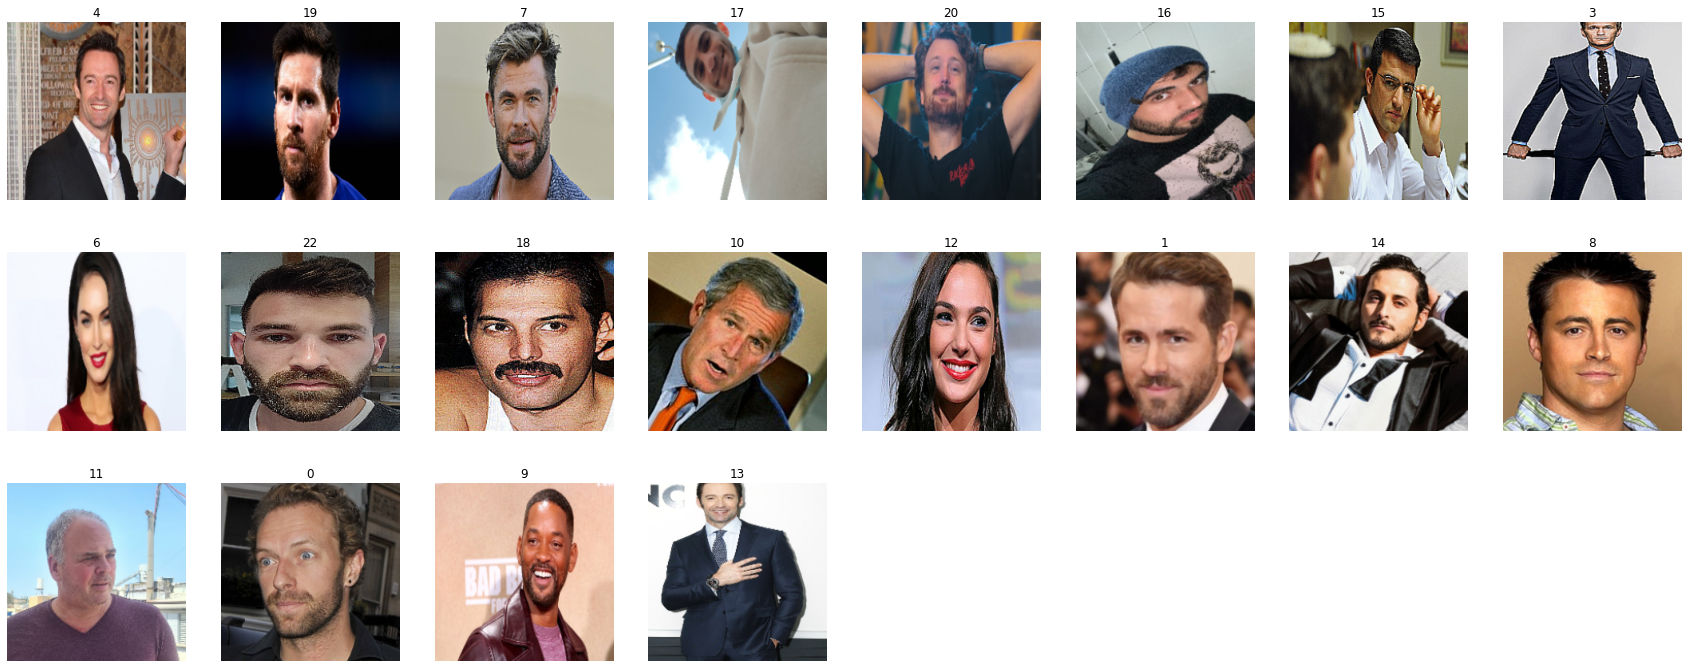

In [ ]:
show_ONE_image_for_all(my_dataset)

In [ ]:
train_dataloader = DataLoader(images_train_dataset ,shuffle=True ,batch_size = 16)
test_dataloader = DataLoader(images_test_dataset,shuffle= False ,batch_size = 16)

In [ ]:
len(images_dataset)

275

# setup tensorboard to follow the graphs 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard 
%reload_ext tensorboard
experiment = 0 

In [ ]:
%tensorboard --logdir=runs

In [ ]:
writer = SummaryWriter()

In [ ]:
def show_graphs(data, kind ='train'):

  # showing accuracy graph
  plt.figure(figsize = (10,6))
  plt.axis('off')
  plt.title(f'{kind} accuracy')
  sns.lineplot(data = data , x= 'index' , y = 'accuracy')
  plt.show()
  #showing loss graph 
  plt.figure(figsize = (10,6))
  plt.axis('off')
  plt.title(f' {kind} loss')
  sns.lineplot(data = data , x= 'index' , y = 'loss')
  plt.show()

In [ ]:
DEBUG = False 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def train(train_loader, model, optimizer, epoch, criterion, writer,TB_try):
  data_graph = pd.DataFrame(columns=['index' , 'accuracy' , 'loss'])
  at_least_95 = 0
  runner = 0 
  model =model.to(device)
  count = 0
  for x in range(1,epoch+1):
    print(f'epoch : {x}')
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()

    for i, (img, target) in enumerate(train_loader):

        img = img.float()    
        target = target.long()
        img = img.to(device)
        #img.to(device)
        target =target.to(device)
        optimizer.zero_grad()
        output = model(img.float())

        if DEBUG:
            print('output',output.detach().cpu().numpy(),
                    'shape', output.detach().cpu().numpy().shape )

            print('target',target.detach().cpu().numpy(),
                    'shape', target.detach().cpu().numpy().shape )

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
    

        pred = output.argmax(dim=1 , keepdim=True)

        acc = torchmetrics.functional.accuracy(pred, target)

        losses.update(loss.item(), img.size(0))
        accuracy.update(acc, img.size(0))
        if float(accuracy.avg ) >=0.95:
          at_least_95 += 1
        if at_least_95 == 15:
          print('done training !')
          return
          print(f'loss : {losses.avg} ,accuracy : {accuracy.avg}')

        writer.add_scalar(f' training {TB_try}/loss', losses.avg,  runner)
        writer.add_scalar(f' training {TB_try}/accuracy', accuracy.avg,  runner)
        data_graph.loc[i] = [runner] +[float(accuracy.avg)] + [float(losses.avg)]
        runner +=1
    print(f'loss : {losses.avg} ,accuracy : {accuracy.avg}')
    show_graphs(data_graph)

        
  

In [ ]:
 """Computes and stores the average and current value"""
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# testing our model 
def test(test_loader, model, criterion, writer , TB_try):
  data_graph = pd.DataFrame(columns=['index' , 'accuracy' , 'loss'])
  model =model.to(device)
  accuracy = AverageMeter()
  losses = AverageMeter()
  runner = 0 
  for i, (img, target) in enumerate(test_loader):

      img = img.float()    
      target = target.long()
      img = img.to(device)
      #img.to(device)
      target =target.to(device)
      output = model(img.float())

      if DEBUG:
          print('output',output.detach().cpu().numpy(),
                  'shape', output.detach().cpu().numpy().shape )

          print('target',target.detach().cpu().numpy(),
                  'shape', target.detach().cpu().numpy().shape )

      loss = criterion(output, target)

      pred = output.argmax(dim=1 , keepdim=True)
      acc = torchmetrics.functional.accuracy(pred, target)
      losses.update(loss.item(), img.size(0))
      accuracy.update(acc, img.size(0))
      writer.add_scalar(f' test {TB_try}/loss', losses.avg,  runner)
      writer.add_scalar(f' test {TB_try}/accuracy', accuracy.avg,  runner)
      data_graph.loc[i] = [runner] +[float(accuracy.avg)] + [float(losses.avg)]
      runner += 1
  print(f'loss : {losses.avg} ,accuracy : {accuracy.avg}')
  show_graphs(data_graph , kind = 'test')
    

In [ ]:
# showing the confusion matrix 
def confusion_matrix_result(model , data_loader):
  gc.collect()
  torch.cuda.empty_cache()
  model.eval()
  all_targets = []
  all_preds = []

  with torch.no_grad():
    for i, (img , target) in enumerate(data_loader):
      img = img.float()
      target = target.long()

      img = img.to(device)
      target = target.to(device)

      output = model(img.float())

      pred = output.argmax(dim = 1 ,keepdim = True)

      all_targets.append(target.detach().cpu().numpy().tolist())
      all_preds.append(pred.detach().cpu().numpy().flatten().tolist())
  all_targets = reduce(lambda a,b :a + b , all_targets)
  all_preds = reduce(lambda a,b : a + b, all_preds)
  
  cm = confusion_matrix(all_targets , all_preds , labels = list(range(24)))
  plt.figure(figsize=(20,10))
  sns.heatmap(cm , annot = True , fmt = "d" , linewidth = .6)
  plt.xlabel("predict labels")
  plt.ylabel("true labels")

In [ ]:
# showing 1 image that the model predict it well and 1 image that the modek predict it wrong
def TP_and_NF(model , data_loader):
  gc.collect()
  torch.cuda.empty_cache()
  model.eval()
  TP_index  = -1
  NF_index  = -1
  torch.no_grad()
  index ,(img ,target) =next( enumerate(data_loader))
  #print(img)
  #print(target)
  img = img.float()
  target = target.long()

  img = img.to(device)
  target = target.to(device)

  output = model(img.float())

  pred = output.argmax(dim = 1 ,keepdim = True)
  pred_list = pred.detach().cpu().numpy().flatten().tolist()
  target_list = target.detach().cpu().numpy().tolist()
  for i in range(len(pred_list)):
    if pred_list[i] == target_list[i]:
      TP_index = i
    if pred_list[i] != target_list[i]:
      NF_index = i
      NF_expected_index = target_list[i]
      NF_predicted_index = pred_list[i]
    if TP_index != -1 and NF_index != -1:
      break
  if TP_index != -1 and NF_index != -1:
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
    
    img =img.int()
    ax1.axis('off')
    ax1.set_title(f'TP :{num_2_name[target_list[TP_index]]}')
    ax1.imshow(np.array(img[TP_index].permute(2,1,0).cpu()))
    ax2.axis('off')
    ax2.set_title(f'NF target : {num_2_name[NF_expected_index]} predicted : {num_2_name[NF_predicted_index]} ')
    ax2.imshow(np.array(img[NF_index].permute(2,1,0).cpu()))
  else:
    print('ERROR 404 : TP or NF not Found')

  
 

In [ ]:
# general function for every model , to train and show graphs and test our model and see the confusion matrix and TP and NF images
max_epoch_number = 30 
def train_model_and_show_graphs(model , train_dataloader ,test_dataloader,writer , TB_try):
  optimizer = torch.optim.Adagrad(model.parameters() ,lr=0.001 , weight_decay= 0.0001)
  critirion = torch.nn.CrossEntropyLoss()

  print('training the model !')
  train(train_dataloader,model=model ,optimizer= optimizer , criterion= critirion , epoch= max_epoch_number ,writer = writer,TB_try = TB_try )

  print('testing the model !')
  test(test_loader= test_dataloader, model = model , criterion= critirion,writer = writer , TB_try = 1)

  print('confusion matrix:')
  confusion_matrix_result(model, test_dataloader)

  print('TP and NF images ')
  TP_and_NF(model , test_dataloader)
  return model 


In [ ]:

#vgg16_model = timm.create_model('vgg16', pretrained = False, num_classes = num_of_classes )
vgg16_model = VGG16(num_classes = num_of_classes)

In [ ]:
vgg16_model = train_model_and_show_graphs(vgg16_model , train_dataloader =train_dataloader  ,test_dataloader = test_dataloader ,writer = writer , TB_try =1 )

In [ ]:
model_inception_v4 = timm.create_model('inception_v4', pretrained=False, num_classes=num_of_classes)

training the model !
epoch : 1
loss : 3.3065838371623646 ,accuracy : 0.06545454263687134
epoch : 2
loss : 2.957074442776767 ,accuracy : 0.11272727698087692
epoch : 3
loss : 2.7211748001792215 ,accuracy : 0.15272727608680725
epoch : 4
loss : 2.629861765774814 ,accuracy : 0.2072727233171463
epoch : 5
loss : 2.5702795323458587 ,accuracy : 0.20363636314868927
epoch : 6
loss : 2.487647196162831 ,accuracy : 0.21090909838676453
epoch : 7
loss : 2.4271747866543856 ,accuracy : 0.23636363446712494
epoch : 8
loss : 2.2942564634843308 ,accuracy : 0.26181817054748535
epoch : 9
loss : 2.2560702115839177 ,accuracy : 0.3199999928474426
epoch : 10
loss : 2.042434653368863 ,accuracy : 0.36000001430511475
epoch : 11
loss : 2.051326037320224 ,accuracy : 0.3527272641658783
epoch : 12
loss : 1.9756701183319092 ,accuracy : 0.38181817531585693
epoch : 13
loss : 1.9584988550706344 ,accuracy : 0.39636364579200745
epoch : 14
loss : 1.7258302532542835 ,accuracy : 0.44727271795272827
epoch : 15
loss : 1.6603162774

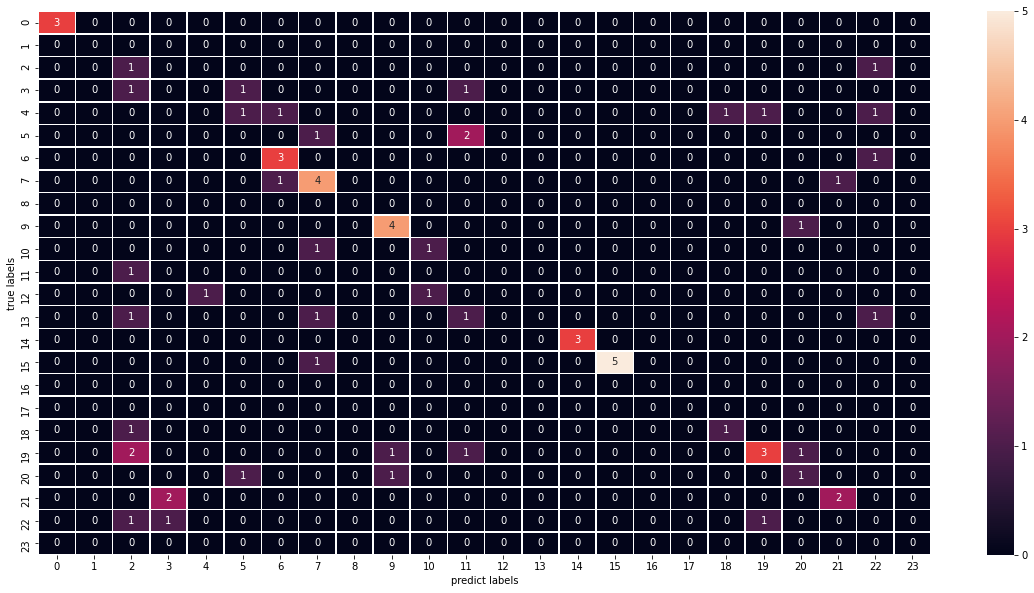

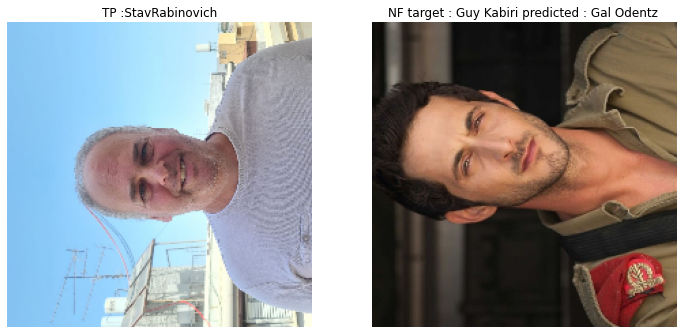

In [ ]:
model_inception_v4 = train_model_and_show_graphs(model_inception_v4 , train_dataloader =train_dataloader  ,test_dataloader = test_dataloader ,writer = writer , TB_try =2 )

In [ ]:
mobile_net_3_model = timm.models.mobilenetv3_large_100(pretrained=True , num_classes = num_of_classes)

training the model !
epoch : 1
loss : 2.283270313089544 ,accuracy : 0.40727272629737854
epoch : 2
loss : 0.24942679578607732 ,accuracy : 0.9672727584838867
epoch : 3
done training !


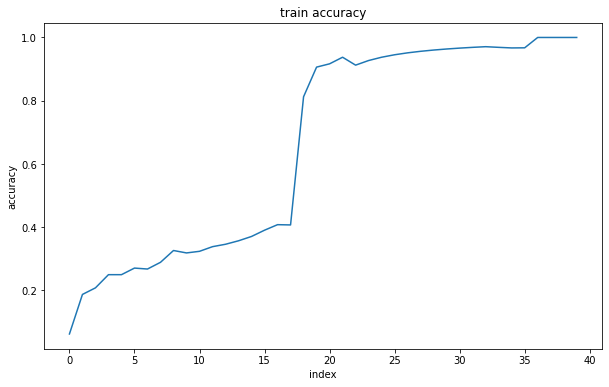

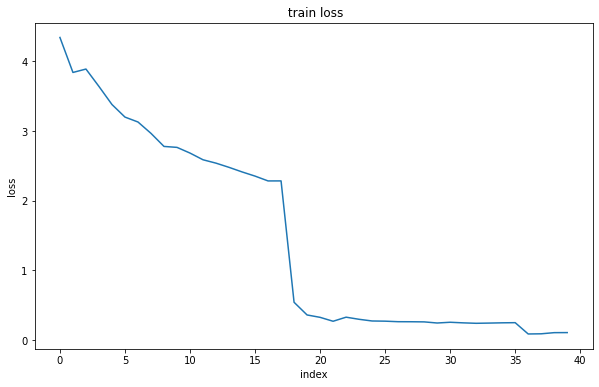

testing the model !
loss : 1.128865815591121 ,accuracy : 0.739130437374115


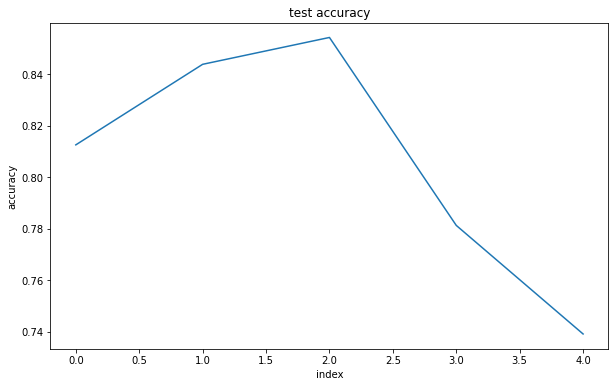

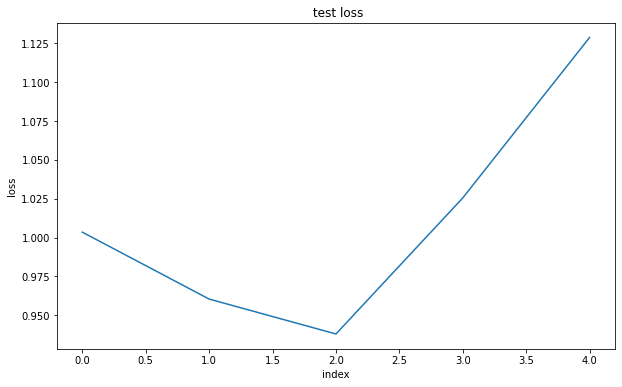

confusion matrix:
TP and NF images 


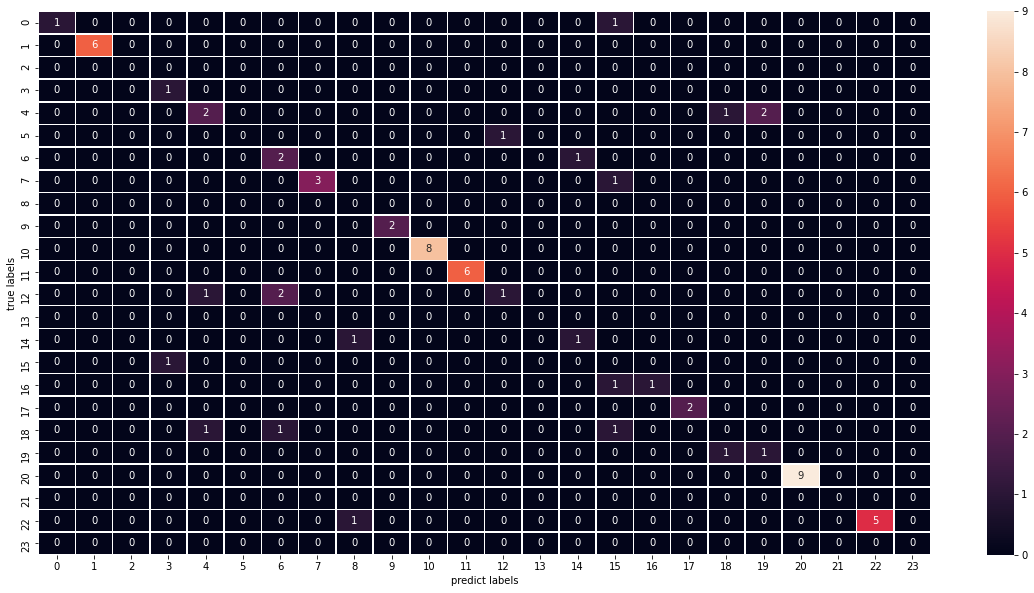

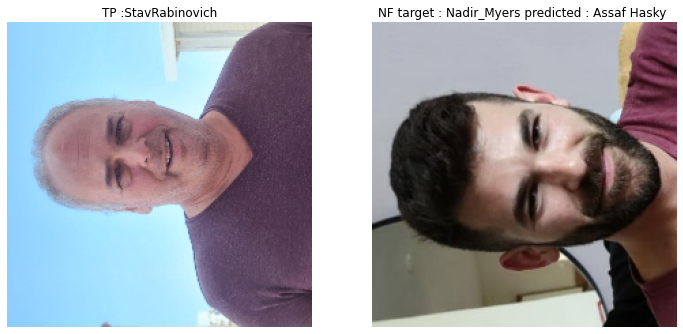

In [ ]:
mobile_net_3_model = train_model_and_show_graphs(mobile_net_3_model , train_dataloader =train_dataloader  ,test_dataloader = test_dataloader ,writer = writer , TB_try =3 )

In [ ]:
model_resnet = timm.models.resnest50d(pretrained= True , num_classes = num_of_classes)


training the model !
epoch : 1
loss : 2.0032414800470524 ,accuracy : 0.44727271795272827
epoch : 2
loss : 0.4854644268209284 ,accuracy : 0.9054545760154724
epoch : 3
done training !
testing the model !
loss : 0.7273316193318021 ,accuracy : 0.7971014380455017
confusion matrix:
TP and NF images 


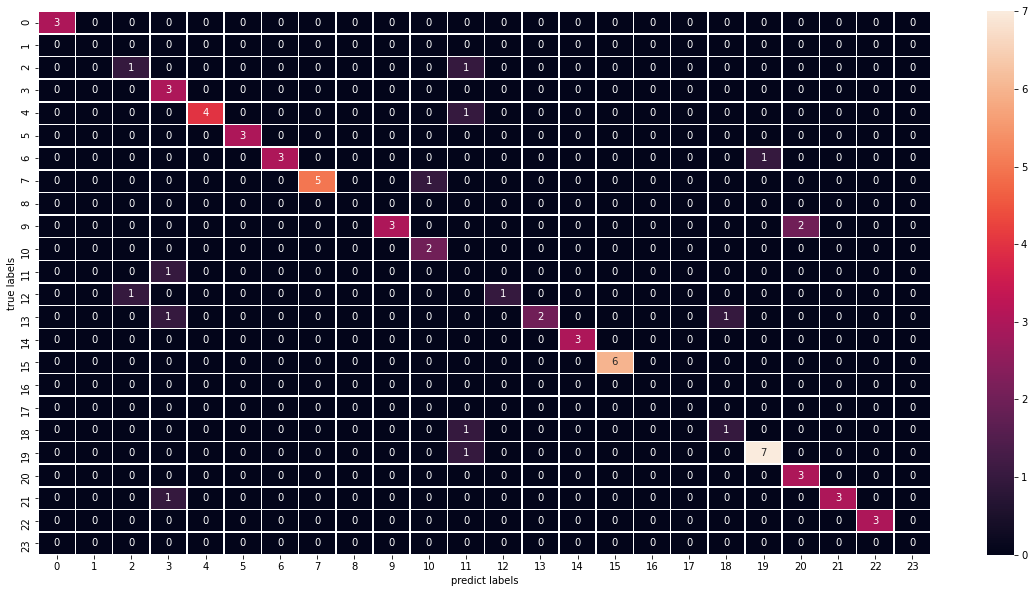

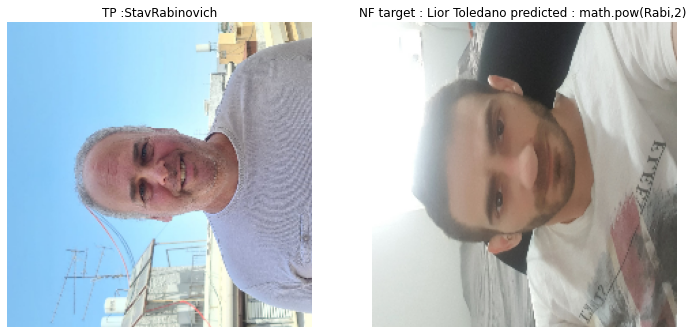

In [ ]:
model_resnet = train_model_and_show_graphs(model_resnet , train_dataloader =train_dataloader  ,test_dataloader = test_dataloader ,writer = writer , TB_try =4 )

In [ ]:
effiecient_net = timm.models.efficientnet_b4(pretrained=False, num_classes = num_of_classes)

training the model !
epoch : 1
loss : 3.908912034468217 ,accuracy : 0.15272727608680725
epoch : 2
loss : 2.27529136874459 ,accuracy : 0.3199999928474426
epoch : 3
loss : 1.7756655432961204 ,accuracy : 0.4727272689342499
epoch : 4
loss : 1.5667382032221013 ,accuracy : 0.5709090828895569
epoch : 5
loss : 1.4350160841508346 ,accuracy : 0.5563636422157288
epoch : 6
loss : 1.2585391967946833 ,accuracy : 0.6363636255264282
epoch : 7
loss : 1.0073948123238303 ,accuracy : 0.7090908885002136
epoch : 8
loss : 0.9466740135713058 ,accuracy : 0.6945454478263855
epoch : 9
loss : 0.9576266970417716 ,accuracy : 0.7272727489471436
epoch : 10
loss : 0.8340101243149151 ,accuracy : 0.7672727108001709
epoch : 11
loss : 0.8444027698040009 ,accuracy : 0.7599999904632568
epoch : 12
loss : 0.6857518139752474 ,accuracy : 0.800000011920929
epoch : 13
loss : 0.5919391942837021 ,accuracy : 0.8290908932685852
epoch : 14
loss : 0.6602924082495949 ,accuracy : 0.800000011920929
epoch : 15
loss : 0.5684273313934153 ,ac

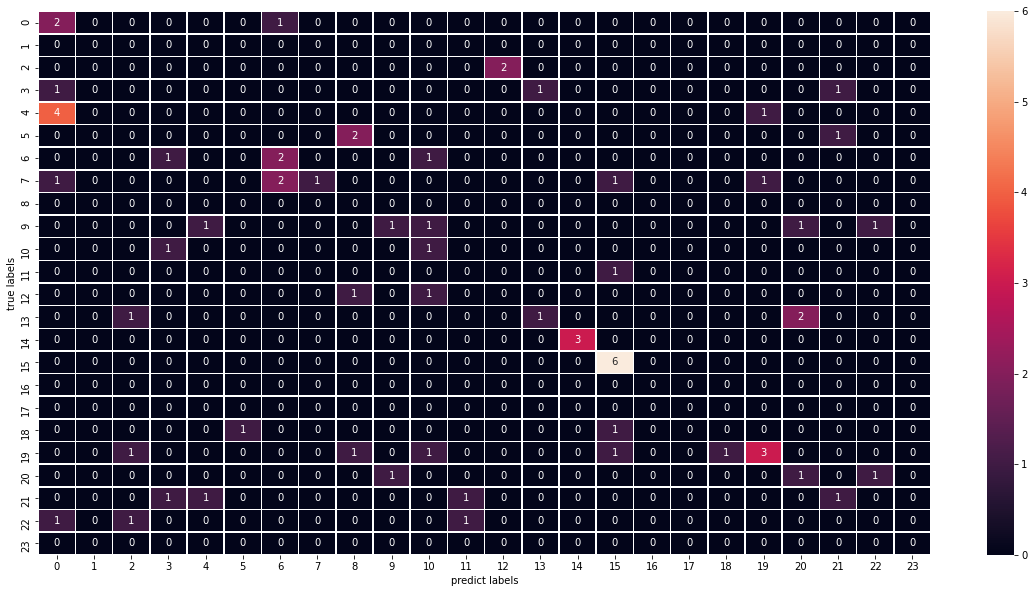

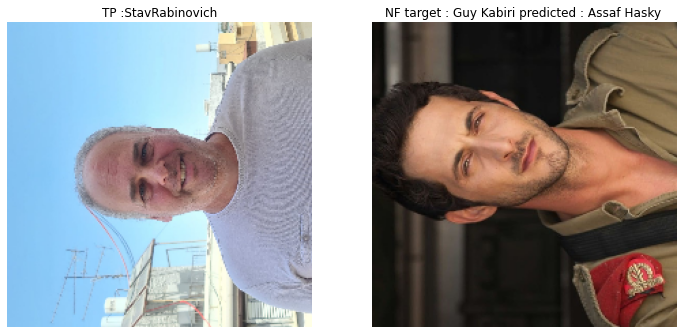

In [ ]:
effiecient_net = train_model_and_show_graphs(effiecient_net , train_dataloader =train_dataloader  ,test_dataloader = test_dataloader ,writer = writer , TB_try =5 )

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
train_dataloader = DataLoader(dataset= images_dataset , batch_size = 4 ,shuffle= True)
test_dataloader = DataLoader (dataset = images_test_dataset , batch_size = 4 , shuffle= False) 

In [ ]:
def test_ensemble(test_loader, criterion, writer , TB_try, models ):
  for model in models:
    model = model.to(device)
  
  accuracy = AverageMeter()
  losses = AverageMeter()
  runner = 0 
  for i, (img, target) in enumerate(test_loader):

      img = img.float()    
      target = target.long()
      img = img.to(device)
      target =target.to(device)
      outputs = []
      for model in models:
        outputs.append(model(img.float()))
     
      output = reduce(lambda x,y :x+y , outputs) 
    
      loss = criterion(output, target)

      pred = output.argmax(dim=1 , keepdim=True)
      acc = torchmetrics.functional.accuracy(pred, target)
      losses.update(loss.item(), img.size(0))
      accuracy.update(acc, img.size(0))
      writer.add_scalar(f' test {TB_try}/loss', losses.avg,  runner)
      writer.add_scalar(f' test {TB_try}/accuracy', accuracy.avg,  runner)
      runner += 1
  print(f'loss : {losses.avg} ,accuracy : {accuracy.avg}')
  return accuracy.avg , models

In [ ]:
  critirion = torch.nn.CrossEntropyLoss()


In [ ]:
# we will extract the powerset of all the models and check for each set of models the accuracy 
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

In [ ]:
all_models = {'resnet':model_resnet , 'mobile_3':mobile_net_3_model , 'inception':model_inception_v4 , 'vgg16':vgg16_model , 'effiecent':effiecient_net}
all_models_comb  = list(powerset(all_models))

In [ ]:
#we pop out the empty group from the set
all_models_comb.pop(0)
print(all_models_comb)

[]

In [ ]:
max_accuracy = 0 
temp_accuracy =0
for comb in all_models_comb:
  my_models = []
  for model in comb:
    my_models.append(all_models[model])
  temp_accuracy , models = test_ensemble(test_dataloader , critirion ,writer ,  6 , my_models )
  if temp_accuracy >max_accuracy :
    max_accuracy = temp_accuracy 
    best_models = models 


loss : 0.5441553480383279 ,accuracy : 0.8115942478179932
loss : 1.1063391782235408 ,accuracy : 0.695652186870575
loss : 0.5441553480383279 ,accuracy : 0.8115942478179932
loss : 0.6699949952949217 ,accuracy : 0.8115942478179932
loss : 2.3967547658560933 ,accuracy : 0.4492753744125366
loss : 0.5441553480383279 ,accuracy : 0.8115942478179932
loss : 1.0441197906283364 ,accuracy : 0.7246376872062683
loss : 1.1063391782235408 ,accuracy : 0.695652186870575
loss : 1.6708341666321824 ,accuracy : 0.5797101259231567
loss : 0.5441553480383279 ,accuracy : 0.8115942478179932
loss : 0.6699949952949217 ,accuracy : 0.8115942478179932
loss : 0.9773607858443174 ,accuracy : 0.739130437374115
loss : 4.092098291369452 ,accuracy : 0.30434784293174744
loss : 0.5441553480383279 ,accuracy : 0.8115942478179932
loss : 2.0313351016113725 ,accuracy : 0.5797101259231567
loss : 1.1063391782235408 ,accuracy : 0.695652186870575
loss : 2.923655362016913 ,accuracy : 0.4637681245803833
loss : 0.5441553480383279 ,accuracy 

In [ ]:
print(f'our best accuracy is {max_accuracy}')
print(f' combination of models : {} : ')

[('resnet',),
 ('mobile_3',),
 ('inception',),
 ('vgg16',),
 ('effiecent',),
 ('resnet', 'mobile_3'),
 ('resnet', 'inception'),
 ('resnet', 'vgg16'),
 ('resnet', 'effiecent'),
 ('mobile_3', 'inception'),
 ('mobile_3', 'vgg16'),
 ('mobile_3', 'effiecent'),
 ('inception', 'vgg16'),
 ('inception', 'effiecent'),
 ('vgg16', 'effiecent'),
 ('resnet', 'mobile_3', 'inception'),
 ('resnet', 'mobile_3', 'vgg16'),
 ('resnet', 'mobile_3', 'effiecent'),
 ('resnet', 'inception', 'vgg16'),
 ('resnet', 'inception', 'effiecent'),
 ('resnet', 'vgg16', 'effiecent'),
 ('mobile_3', 'inception', 'vgg16'),
 ('mobile_3', 'inception', 'effiecent'),
 ('mobile_3', 'vgg16', 'effiecent'),
 ('inception', 'vgg16', 'effiecent'),
 ('resnet', 'mobile_3', 'inception', 'vgg16'),
 ('resnet', 'mobile_3', 'inception', 'effiecent'),
 ('resnet', 'mobile_3', 'vgg16', 'effiecent'),
 ('resnet', 'inception', 'vgg16', 'effiecent'),
 ('mobile_3', 'inception', 'vgg16', 'effiecent'),
 ('resnet', 'mobile_3', 'inception', 'vgg16', 'eff

# Summary :

#### 1) optimization choosed  is adagrad , adamw and adam most of the times failed to converge in range less than 30 epoch (this is the maximum amount we can do ) , adagrad did a great results and most of the time converge 
#### 2) critirtion choosed is crossentropy ( very suitable for classifacations ) 

#### 3) mobile net v3 model and resnet model trained super fast ( very strange to me ) , after 3 epochs reached more than 95% accuracy 

#### 4) final score reached is 81% accuracy 

#### 5) most of the time the tensorboard crashed so am giving up on tensorboard and living it in the notebook and showing graphs using dataframe and plt 